# Stoneburner, Kurt
- ## DSC 630 - Week 05 Code

**This code is a giant jumble of dead ends. I spent a lot of time performing EDA looking for linear relationships where there weren't any. It took a lot of effort to get my head wrapped around ultimately turned out to be a straightforward process.**

**Instructions for Reference**
Online travel agencies are scrambling to meet the artificial intelligence driven personalization standard set by companies like Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.

The data set can be found at Kaggle: Expedia Hotel Recommendations. To get started, I would suggest exploring the file train.csv, which contains the logs of user behavior.  There is another file named destinations.csv, which contains information related to hotel reviews made by users. There is a lot of data here, and making an accurate prediction is rather difficult, e.g., simply running a standard prediction algorithm will probably yield below 10% accuracy. Stary by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv). Then, build at least two prediction models from the training set, and report the accuracies on the test set. As I mentioned, this is a difficult problem, so be creative with your solutions. You might want to try building your own predictor rather than a standard predictor model, e.g., a random forest.  The purpose of this project is not necessarily to get great results but to understand the nuances and challenges of such problems.


(Keeping track of items for reference that can be used in future assignments. I refer, because I can't remember)

CODE Examples:
- Read/Write CSV with compression
- Good PCA Example
- Time Date Conversion of Columns to be used in date calculations. Use .astype('timedelta64[h]') to find the difference in datetime in hours.
- Test Train Split
- Basic Modeling scoring and accuracy
- Decision Tree Classifier: from sklearn.tree import DecisionTreeClassifier
- (KNN) K Nearest Neighbors: 

- Pickle Dataframe df.to_pickle(filenaa)
References:
- Basic PCA and general problem solving: https://www.dataquest.io/blog/kaggle-tutorial/
- Random Forest Classifier: https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f
- GridSearchCV: https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
- Test Train Split: https://towardsdatascience.com/how-to-split-a-dataframe-into-train-and-test-set-with-python-eaa1630ca7b3?gi=3eb5657e8112



In [1]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

One time conversion from CSV to Compressed CSV

In [2]:
"""
#//*** Resave each CSV as a compressed CSV
import os
path =f'./ignore/wk05/'
list_of_files = ['destinations.csv','sample_submission.csv','test.csv','train.csv']

for name in list_of_files:
    name = f"{path}{name}"
    print(f"Read/Write {name}")
    pd.read_csv(name).to_csv(f"{name}.zip", compression="zip", index=False)

print("done")
"""

'\n#//*** Resave each CSV as a compressed CSV\nimport os\npath =f\'./ignore/wk05/\'\nlist_of_files = [\'destinations.csv\',\'sample_submission.csv\',\'test.csv\',\'train.csv\']\n\nfor name in list_of_files:\n    name = f"{path}{name}"\n    print(f"Read/Write {name}")\n    pd.read_csv(name).to_csv(f"{name}.zip", compression="zip", index=False)\n\nprint("done")\n'

Import Destinations and Training data set. 

In [9]:

import time

path =f'./ignore/wk05/'
list_of_files = ['destinations.csv.zip','sample_submission.csv.zip','test.csv.zip','train.csv.zip']

for file in list_of_files:
    print(f"Reading:{path}{file}")
    if file == 'destinations.csv.zip':
        start_time = time.time()
        dest_df = pd.read_csv(f"{path}{file}")
        print(f"Read:{path}{file} - {round(time.time()-start_time,2)}s")
        continue
    #if file == 'sample_submission.csv.zip':
    #    start_time = time.time()
    #    submit_df = pd.read_csv(f"{path}{file}")
    #    print(f"Read:{path}{file} - {round(time.time()-start_time,2)}s")
    #    continue
    #if file == 'test.csv.zip':
    #    start_time = time.time()
    #    test_df = pd.read_csv(f"{path}{file}")
    #    print(f"Read:{path}{file} - {round(time.time()-start_time,2)}s")
    #    print(f"Converting Date...")
    #    test_df['date_time'] = pd.to_datetime(test_df['date_time'])
    #    print(f"Date Converted - {round(time.time()-start_time,2)}s")
    #    continue
    if file == 'train.csv.zip':
        start_time = time.time()
        train_df = pd.read_csv(f"{path}{file}")
        print(f"Read:{path}{file} - {round(time.time()-start_time,2)}s")
        start_time = time.time()
        print(f"Converting Date...")
        
        #//*** Only use records that were bookings. 3million records, 7% of the total records
        train_df = train_df[train_df['is_booking'] == 1]
        
        #//*** Convert Date Columns to Datetime
        train_df['date_time'] = pd.to_datetime(train_df['date_time'])
        train_df['srch_ci'] = pd.to_datetime(train_df['srch_ci'])
        train_df['srch_co'] = pd.to_datetime(train_df['srch_co'])
        
        #//**** Build Length of Stay in hours
        train_df['stay'] = (train_df['srch_co'] - train_df['srch_ci']).astype('timedelta64[h]')

        #//*** Build the booking lead time. This is the time between booking and check in. 
        train_df['lead'] = (train_df['srch_co'] - train_df['date_time']).astype('timedelta64[h]')

        #//*** Borrowed these features from the Kaggle Tutorial
        #//*** Turns out they weren't super helpful at all. But generates an integer based on check in/out, month, day, day of week, quarter
        date_props = ["month", "day", "dayofweek", "quarter"]
        for prop in date_props:
            train_df[f"ci_{prop}"] = getattr(train_df["srch_ci"].dt, prop)
            train_df[f"co_{prop}"] = getattr(train_df["srch_co"].dt, prop)

        print(f"Date Converted - {round(time.time()-start_time,2)}s")
        continue




Reading:./ignore/wk05/destinations.csv.zip
Read:./ignore/wk05/destinations.csv.zip - 1.83s
Reading:./ignore/wk05/sample_submission.csv.zip
Reading:./ignore/wk05/test.csv.zip
Reading:./ignore/wk05/train.csv.zip
Read:./ignore/wk05/train.csv.zip - 200.19s
Converting Date...
Date Converted - 18.0s


In [ ]:
train_df

Perform PCA. I borrowed this code from elsewhere.
I have a rudimentary understanding of PCA.
This code transforms 150 columns into 3 while preserving the variance. I recognize there is a whole thought process into testing and validating this value. In my case, I just copy/pasted.

In [6]:
#//**** Convert Destinations to 3 columns using PCA
#//*** Code Stolen From: https://www.dataquest.io/blog/kaggle-tutorial/
#//*** Explainer for PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
dest_small = pca.fit_transform(dest_df[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = dest_df["srch_destination_id"]
dest_small
dest_small.columns = ['sf1','sf2','sf3','srch_destination_id']

In [90]:

#//*** generate an ordered list of popular destinations by frequency. Destinations are exponentially distributed.  Initial runs tested on the top 10 and top 100 destinations. The thinking being there are more data points to relate to.
#//*** This helped speed up the initials testing phase. It was not needed once I shifted the dataset to only using bookings
dest_count = 1000

#//*** Keeping dest_count since it is stored in a results data frame
dest_count = len(train_df)

#//*** Build destination list ordered by popularity (frequency)
pop_dest = list(train_df['srch_destination_id'].value_counts().sort_values(ascending=False).index[:dest_count])
pop_dest

#//*** Build a temporary dataframe from destinations that are in pop_dest
tdf = train_df[train_df['srch_destination_id'].isin(pop_dest)]
#//*** Reference Length
print(len(tdf))

#//*** Merge the tdf (training data) with the PCA destinations
tdf = pd.merge(tdf,dest_small,on='srch_destination_id')

#//*** Should be same as reference length
print(len(tdf))
#//*** Columns to remove. This feature reduction keeps things more manageable/readable
rem_cols = ['date_time', 'posa_continent','user_location_country','user_location_region', 'user_id','is_mobile','is_package','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','is_booking','cnt','hotel_continent','hotel_country','hotel_market']
rem_cols = ['date_time', 'posa_continent','user_location_country','user_id','is_mobile','is_package','srch_rm_cnt','is_booking','cnt','hotel_continent','hotel_country']

#//*** Remove columns in list
for col in rem_cols:
    if col in tdf.columns:
        del tdf[col]
#//*** Replace NA with -1. This is a field expedient
tdf.fillna(-1, inplace=True)
tdf

3000693
2988177


,site_name,user_location_region,user_location_city,orig_destination_distance,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_destination_id,srch_destination_type_id,hotel_market,hotel_cluster,stay,lead,ci_month,co_month,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,sf1,sf2,sf3
0,2,348,48862,2234.2641,9,2014-08-29,2014-09-02,2,0,8250,1,628,1,96.0,519.0,8,9,29,2,4,1,3,3,2.168369,-0.061117,0.723259
1,13,171,15334,5655.3159,9,2014-07-31,2014-08-02,2,2,8250,1,628,1,48.0,6107.0,7,8,31,2,3,5,3,3,2.168369,-0.061117,0.723259
2,2,356,4751,762.2315,9,2015-01-16,2015-01-19,2,0,8250,1,628,45,72.0,1934.0,1,1,16,19,4,0,1,1,2.168369,-0.061117,0.723259
3,24,51,41641,-1.0000,9,2014-12-29,2014-12-30,1,0,8250,1,628,1,24.0,1298.0,12,12,29,30,0,1,4,4,2.168369,-0.061117,0.723259
4,11,155,14703,996.3811,9,2014-01-09,2014-01-10,2,0,8250,1,628,19,24.0,150.0,1,1,9,10,3,4,1,1,2.168369,-0.061117,0.723259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988172,17,0,32356,-1.0000,9,2014-10-24,2014-10-25,2,0,48869,3,170,44,24.0,66.0,10,10,24,25,4,5,4,4,-0.538166,-0.027306,-0.024202
2988173,2,442,35390,63.9810,9,2014-03-01,2014-03-02,1,0,59406,4,1266,77,24.0,117.0,3,3,1,2,5,6,1,1,-0.487888,0.019144,0.004337
2988174,2,38,42328,-1.0000,9,2014-09-25,2014-09-26,2,2,43465,3,243,44,24.0,81.0,9,9,25,26,3,4,3,3,-0.552366,-0.031514,-0.034742
2988175,2,351,36508,501.2726,9,2013-05-20,2013-05-25,1,0,4360,3,529,83,120.0,250.0,5,5,20,25,0,5,2,2,-0.462131,-0.022994,0.007314


In [8]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [85]:
#//*****************************************
#//*** Decision Tree Classifier Model
#//*****************************************
from sklearn.tree import DecisionTreeClassifier

#//*** Label for saving results
model_label = "DecisionTreeClassifier"


#//*** Size of dataset for saving with results
size = len(tdf)

#//*** Columns used in Modeling.
#//*** Laid out like this for iterative trial and error
cols = [
    'site_name',
    'user_location_city',
    #'user_location_region',
    'orig_destination_distance',
    #'channel',
    'srch_destination_id',
    #'srch_destination_type_id',
    #'srch_adults_cnt',
    #'srch_children_cnt',]
    #'stay',
    #'lead',
    #'ci_month',
    #'co_month',
    #'ci_day',
    #'co_day',
    #'ci_dayofweek',
    #'co_dayofweek',
    #'ci_quarter',
    #'co_quarter',
    'sf1',
    'sf2',
    'sf3',]

#//*** Dependent Variable columns for training
x = tdf[cols]

#//*** Needed for saving results, specifically for KNN later
n=3

#//*** Independent variable
target = tdf['hotel_cluster']

#//*** Test Train Split
x_train,x_test,y_train,y_test=train_test_split(x,target,test_size=0.8,random_state=0)

#//*** Initialize decision tree. Setting random state for reproduceability
decisiontree = DecisionTreeClassifier(random_state=0)

#//*** Initialize the model
model = decisiontree.fit(x_train,y_train)

print("Building Predictions")
start_time=time.time()

#//*** Fit the Model
model.fit(x_train, y_train)

predict_time = round(time.time()-start_time,2)
print(f"Predictions Built: {predict_time}s")

start_time=time.time()

#//*** Score the model
score = model.score(x_train, y_train)
print("Score: ", score)

#//*** generate results (ie predictions)
result = model.predict(x)

predict_time = round(time.time()-start_time,2)
print(f"Predictions Built: {predict_time}s")

print(result)
#//*** Evaluate Model
#//*** Mean Squared Error
mse = mean_squared_error(target, result)

#//*** Root Mean squared Error
rmse = sqrt(mse)
print(rmse)

#//*** Generate Accuracy
acc = metrics.accuracy_score(target, result)
print(acc)

#//*** Save Results to a dataframe (which I may or may not have properly saved :/)
all_results_df.loc[len(all_results_df)] = [model_label,acc,rmse,n,cols,predict_time,dest_count,size]

all_results_df

Building Predictions
Predictions Built: 8.52s
Score:  0.9217666301337774
Predictions Built: 2.43s
[ 1  1 54 ... 44 83 78]
33.91952758929231
0.3274936524844412


,model,accuracy,rmse,n,cols,time,dest_count,size
0,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.51,2988177,10
1,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.63,100,2988177
2,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.63,1000,2988177
3,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.59,1000,2988177
4,DecisionTreeClassifier,0.283487,36.380468,3,"[site_name, user_location_region, orig_destina...",0.85,100,1061781
5,DecisionTreeClassifier,0.290333,35.409561,3,"[site_name, user_location_region, orig_destina...",1.81,1000,2165285
6,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.88,3000693,2988177
7,DecisionTreeClassifier,0.311323,34.323223,3,"[site_name, user_location_region, orig_destina...",2.43,3000693,2988177
8,DecisionTreeClassifier,0.309693,34.789923,3,"[orig_destination_distance, srch_destination_i...",2.17,3000693,2988177
9,DecisionTreeClassifier,0.215614,37.921567,3,"[user_location_region, srch_destination_id, sr...",1.98,3000693,2988177


Run 14 has the best results

In [60]:
for x in [7,10,11,12,14]:
    print(x,all_results_df.loc[x]['cols'])


7 ['site_name', 'user_location_region', 'orig_destination_distance', 'channel', 'srch_destination_id', 'srch_destination_type_id', 'srch_adults_cnt', 'srch_children_cnt', 'sf1', 'sf2', 'sf3']
10 ['site_name', 'user_location_region', 'orig_destination_distance', 'srch_destination_id', 'srch_destination_type_id', 'sf1', 'sf2', 'sf3']
11 ['site_name', 'user_location_city', 'orig_destination_distance', 'srch_destination_id', 'srch_destination_type_id', 'sf1', 'sf2', 'sf3']
12 ['site_name', 'user_location_city', 'user_location_region', 'orig_destination_distance', 'srch_destination_id', 'srch_destination_type_id', 'sf1', 'sf2', 'sf3']
14 ['site_name', 'user_location_city', 'orig_destination_distance', 'srch_destination_id', 'sf1', 'sf2', 'sf3']


In [ ]:
#//*** Save results to a file. Use pickling to preserve the list
all_results_df.to_pickle('z_wk05_all_results_df.pkl')

In [17]:
#all_results_df = pd.DataFrame(columns=['model','accuracy','rmse','n','cols','time','dest_count','size'])

In [280]:
#//*** Build the dataset TDF again. KNN was greatly affected by outliers. It worked better on the more popular destinations. Probably because they had more neighbors.
tdf = train_df.copy()
tdf

pop_dest = list(tdf['srch_destination_id'].value_counts().sort_values(ascending=False).index)

tdf = tdf[tdf['srch_destination_id'].isin(pop_dest)]

#//*** Remove unused columns
rem_cols = ['date_time', 'posa_continent','user_location_country','user_location_region', 'user_id','is_mobile','is_package','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','is_booking','cnt','hotel_continent','hotel_country','hotel_market']

for col in rem_cols:
    if col in tdf.columns:
        del tdf[col]
tdf = pd.merge(tdf,dest_small,on='srch_destination_id')
tdf.fillna(-1, inplace=True)
tdf

,site_name,user_location_city,orig_destination_distance,channel,srch_ci,srch_co,srch_destination_id,srch_destination_type_id,hotel_cluster,stay,lead,ci_month,co_month,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,sf1,sf2,sf3
0,2,48862,2234.2641,9,2014-08-29,2014-09-02,8250,1,1,96.0,519.0,8,9,29,2,4,1,3,3,2.168369,-0.061117,0.723256
1,13,15334,5655.3159,9,2014-07-31,2014-08-02,8250,1,1,48.0,6107.0,7,8,31,2,3,5,3,3,2.168369,-0.061117,0.723256
2,2,4751,762.2315,9,2015-01-16,2015-01-19,8250,1,45,72.0,1934.0,1,1,16,19,4,0,1,1,2.168369,-0.061117,0.723256
3,24,41641,-1.0000,9,2014-12-29,2014-12-30,8250,1,1,24.0,1298.0,12,12,29,30,0,1,4,4,2.168369,-0.061117,0.723256
4,11,14703,996.3811,9,2014-01-09,2014-01-10,8250,1,19,24.0,150.0,1,1,9,10,3,4,1,1,2.168369,-0.061117,0.723256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061776,2,47535,1038.0561,9,2013-10-31,2013-11-03,11569,1,79,72.0,345.0,10,11,31,3,3,6,4,4,1.291627,0.541097,0.073918
1061777,2,12346,56.6544,0,2014-09-14,2014-09-15,11569,1,79,24.0,229.0,9,9,14,15,6,0,3,3,1.291627,0.541097,0.073918
1061778,2,2433,160.9706,9,2014-06-21,2014-06-22,11569,1,4,24.0,33.0,6,6,21,22,5,6,2,2,1.291627,0.541097,0.073918
1061779,34,19334,2473.4146,9,2014-08-04,2014-08-05,11569,1,0,24.0,463.0,8,8,4,5,0,1,3,3,1.291627,0.541097,0.073918


In [89]:
#test_results_df = pd.DataFrame(columns=['accuracy','rmse','n','cols','time','size'])
tdf

,site_name,user_location_region,user_location_city,orig_destination_distance,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_destination_id,srch_destination_type_id,hotel_cluster,stay,lead,ci_month,co_month,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,sf1,sf2,sf3
0,2,348,48862,2234.2641,9,2014-08-29,2014-09-02,2,0,8250,1,1,96.0,519.0,8,9,29,2,4,1,3,3,2.168369,-0.061117,0.723259
1,13,171,15334,5655.3159,9,2014-07-31,2014-08-02,2,2,8250,1,1,48.0,6107.0,7,8,31,2,3,5,3,3,2.168369,-0.061117,0.723259
2,2,356,4751,762.2315,9,2015-01-16,2015-01-19,2,0,8250,1,45,72.0,1934.0,1,1,16,19,4,0,1,1,2.168369,-0.061117,0.723259
3,24,51,41641,-1.0000,9,2014-12-29,2014-12-30,1,0,8250,1,1,24.0,1298.0,12,12,29,30,0,1,4,4,2.168369,-0.061117,0.723259
4,11,155,14703,996.3811,9,2014-01-09,2014-01-10,2,0,8250,1,19,24.0,150.0,1,1,9,10,3,4,1,1,2.168369,-0.061117,0.723259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988172,17,0,32356,-1.0000,9,2014-10-24,2014-10-25,2,0,48869,3,44,24.0,66.0,10,10,24,25,4,5,4,4,-0.538166,-0.027306,-0.024202
2988173,2,442,35390,63.9810,9,2014-03-01,2014-03-02,1,0,59406,4,77,24.0,117.0,3,3,1,2,5,6,1,1,-0.487888,0.019144,0.004337
2988174,2,38,42328,-1.0000,9,2014-09-25,2014-09-26,2,2,43465,3,44,24.0,81.0,9,9,25,26,3,4,3,3,-0.552366,-0.031514,-0.034742
2988175,2,351,36508,501.2726,9,2013-05-20,2013-05-25,1,0,4360,3,83,120.0,250.0,5,5,20,25,0,5,2,2,-0.462131,-0.022994,0.007314


In [95]:
#//*** Begin Nearest neighbors
size = len(tdf)

#//*** Select Columns
cols = [
    'site_name',
    'user_location_city',
    #'user_location_region',
    'orig_destination_distance',
    #'channel',
    #'srch_destination_id',
    'hotel_market',
    'srch_destination_type_id',
    'srch_adults_cnt',
    'srch_children_cnt',
    #'stay',
    #'lead',
    #'ci_month',
    #'co_month',
    #'ci_day',
    #'co_day',
    #'ci_dayofweek',
    #'co_dayofweek',
    #'ci_quarter',
    #'co_quarter',
    'sf1',
    'sf2',
    'sf3',]
 
#//*** Label for saving to all_results_df
model_label = "knn"
x = tdf[cols]

n=3


target = tdf['hotel_cluster']

x_train,x_test,y_train,y_test=train_test_split(x,target,test_size=0.8,random_state=0)

model = KNeighborsClassifier(n_neighbors = n )
print("Fitting Model")
start_time=time.time()
model.fit(x_train,y_train)
print(f"Model Fitted: {round(time.time()-start_time,2)}s")
print(model)

print("Building Predictions")
start_time=time.time()

result = model.predict(x_test)
predict_time = round(time.time()-start_time,2)
print(f"Predictions Built: {predict_time}s")

print(result)

mse = mean_squared_error(y_test, result)
rmse = sqrt(mse)
print(rmse)

acc = metrics.accuracy_score(y_test, result)
print(acc)

#test_results_df.loc[len(test_results_df)] = [acc,rmse,n,knn_cols,predict_time,size]
all_results_df.loc[len(all_results_df)] = [model_label,acc,rmse,n,cols,predict_time,dest_count,size]
all_results_df

Fitting Model
Model Fitted: 5.9s
KNeighborsClassifier(n_neighbors=3)
Building Predictions
Predictions Built: 103.6s
[79  7  6 ... 13 42 28]
40.69205026099038
0.0888877919735357


,model,accuracy,rmse,n,cols,time,dest_count,size
0,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.51,2988177,10
1,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.63,100,2988177
2,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.63,1000,2988177
3,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.59,1000,2988177
4,DecisionTreeClassifier,0.283487,36.380468,3,"[site_name, user_location_region, orig_destina...",0.85,100,1061781
5,DecisionTreeClassifier,0.290333,35.409561,3,"[site_name, user_location_region, orig_destina...",1.81,1000,2165285
6,DecisionTreeClassifier,0.300570,34.574258,3,"[site_name, user_location_region, orig_destina...",2.88,3000693,2988177
7,DecisionTreeClassifier,0.311323,34.323223,3,"[site_name, user_location_region, orig_destina...",2.43,3000693,2988177
8,DecisionTreeClassifier,0.309693,34.789923,3,"[orig_destination_distance, srch_destination_i...",2.17,3000693,2988177
9,DecisionTreeClassifier,0.215614,37.921567,3,"[user_location_region, srch_destination_id, sr...",1.98,3000693,2988177


In [131]:
#all_results_df = pd.DataFrame(columns=['accuracy','rmse','n','cols','time'])
#all_results_df.loc[len(all_results_df)] = [acc,rmse,n,cols,predict_time]
#all_results_df


,accuracy,rmse,n,cols,time
0,0.219591,37.82743,10,"[hotel_market, user_location_city, channel, si...",149.25


# ======================================================================================================================================== #
# ======================================================================================================================================== #
# ======================================================================================================================================== #
# Below is a jumble of exploration and dead ends. It's there to show I spent a lot of time going down the wrong path. A couple of the unlabeled graphs are pretty though. #
# ======================================================================================================================================== #
# ======================================================================================================================================== #
# ======================================================================================================================================== #

In [252]:
train_df[train_df['hotel_market'] == 628]

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
25,2014-11-10 12:38:02,2,3,66,318,48382,1753.2617,776,0,1,9,2015-01-22,2015-01-24,1,0,1,8250,1,0,1,2,50,628,24
373,2014-04-29 16:32:53,2,3,66,174,16634,382.6993,3313,0,1,0,2014-07-23,2014-07-26,2,0,1,8250,1,0,1,2,50,628,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37670243,2014-10-06 12:55:07,34,3,205,155,19334,947.3629,1197813,0,1,5,2014-12-07,2014-12-11,2,0,1,8250,1,0,1,2,50,628,24
37670244,2014-10-06 14:15:14,34,3,205,155,19334,947.3629,1197813,0,1,5,2014-12-10,2014-12-13,2,0,1,8250,1,0,2,2,50,628,24
37670245,2014-10-06 14:37:35,34,3,205,155,19334,948.3004,1197813,0,1,5,2014-12-06,2014-12-10,2,0,1,8250,1,0,2,2,50,628,45
37670272,2013-09-16 16:10:11,2,3,66,174,24103,229.1612,1198173,1,0,2,2013-09-18,2013-09-19,2,0,1,12206,6,0,2,2,50,628,18


In [246]:
#tdf = pd.merge(train_df['hotel_cluster', dest_df, on='srch_destination_id', how='left')

train_df[train_df['srch_destination_id'] == 8250]

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
25,2014-11-10 12:38:02,2,3,66,318,48382,1753.2617,776,0,1,9,2015-01-22,2015-01-24,1,0,1,8250,1,0,1,2,50,628,24
373,2014-04-29 16:32:53,2,3,66,174,16634,382.6993,3313,0,1,0,2014-07-23,2014-07-26,2,0,1,8250,1,0,1,2,50,628,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37670241,2014-10-06 12:35:05,34,3,205,155,19334,949.2368,1197813,0,1,5,2014-12-10,2014-12-14,2,0,1,8250,1,0,3,2,50,628,19
37670242,2014-10-06 12:40:55,34,3,205,155,19334,948.5235,1197813,0,1,5,2014-12-07,2014-12-11,2,0,1,8250,1,0,2,2,50,628,1
37670243,2014-10-06 12:55:07,34,3,205,155,19334,947.3629,1197813,0,1,5,2014-12-07,2014-12-11,2,0,1,8250,1,0,1,2,50,628,24
37670244,2014-10-06 14:15:14,34,3,205,155,19334,947.3629,1197813,0,1,5,2014-12-10,2014-12-13,2,0,1,8250,1,0,2,2,50,628,24


In [244]:
train_df[train_df['srch_destination_id'] == 8250].corr()



,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
site_name,1.000000,-0.509780,0.420286,0.128504,0.020508,0.183869,0.018984,0.009489,0.133443,0.046566,0.004618,-0.012588,-0.003523,NaN,NaN,-0.015815,0.046723,NaN,NaN,-0.007447,-0.002369
posa_continent,-0.509780,1.000000,0.070587,-0.169269,0.009663,-0.223295,-0.013284,-0.005657,-0.014296,0.058274,-0.013202,-0.012254,-0.019922,NaN,NaN,0.006707,-0.000922,NaN,NaN,0.002062,0.008857
user_location_country,0.420286,0.070587,1.000000,0.046535,0.100149,0.101537,-0.019588,-0.003706,0.186638,0.082665,0.021495,-0.008242,-0.001506,NaN,NaN,-0.010676,0.053903,NaN,NaN,-0.007869,-0.012475
user_location_region,0.128504,-0.169269,0.046535,1.000000,0.109439,0.448672,-0.004369,0.017274,0.127105,-0.013142,0.009034,-0.020344,0.002628,NaN,NaN,-0.004838,0.015656,NaN,NaN,-0.004575,-0.023696
user_location_city,0.020508,0.009663,0.100149,0.109439,1.000000,0.072441,-0.012124,-0.003282,0.039358,0.013596,0.004929,-0.013872,0.000450,NaN,NaN,-0.002568,0.009659,NaN,NaN,-0.000930,-0.008792
orig_destination_distance,0.183869,-0.223295,0.101537,0.448672,0.072441,1.000000,0.023374,-0.032284,0.169891,-0.003920,-0.004479,-0.020381,-0.007013,NaN,NaN,-0.020163,0.029408,NaN,NaN,-0.012456,-0.035613
user_id,0.018984,-0.013284,-0.019588,-0.004369,-0.012124,0.023374,1.000000,-0.004236,-0.017686,0.004438,-0.004422,0.008991,0.001013,NaN,NaN,0.002979,-0.001440,NaN,NaN,-0.000333,0.004246
is_mobile,0.009489,-0.005657,-0.003706,0.017274,-0.003282,-0.032284,-0.004236,1.000000,0.050061,-0.042307,0.006569,-0.000488,-0.025362,NaN,NaN,-0.039020,-0.008396,NaN,NaN,0.002556,-0.001582
is_package,0.133443,-0.014296,0.186638,0.127105,0.039358,0.169891,-0.017686,0.050061,1.000000,0.010039,-0.055748,-0.155315,-0.055457,NaN,NaN,-0.017035,0.183496,NaN,NaN,-0.016409,-0.087920
channel,0.046566,0.058274,0.082665,-0.013142,0.013596,-0.003920,0.004438,-0.042307,0.010039,1.000000,-0.015524,-0.004438,0.009261,NaN,NaN,0.013451,0.000091,NaN,NaN,-0.005663,0.008886


In [245]:
dest_df[dest_df['srch_destination_id'] == 8250]

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
8036,8250,-2.283946,-2.346645,-2.400912,-2.36719,-2.273226,-1.722868,-2.392862,-2.381387,-2.239271,-2.259266,-2.305731,-2.400912,-2.369545,-1.712277,-2.399467,-1.901553,-2.065535,-2.384672,-2.399649,-1.140066,-2.354545,-2.400596,-2.400912,-2.365183,-2.397435,-2.365331,-2.397981,-2.36363,-1.675819,-2.194497,-2.400912,-2.399802,-2.398695,-2.392615,-2.209667,-2.317894,-1.281688,-2.398314,-2.37445,-2.370005,-2.031847,-2.38759,-1.645141,-2.400912,-2.37857,-2.364266,-2.397885,-2.355131,-1.349492,-2.3731,-2.3975,-2.348903,-2.241532,-2.400534,-2.207067,-2.305964,-2.397016,-2.241567,-2.393153,-2.399966,-2.38017,-2.391761,-2.399015,-2.400506,-2.400912,-2.363137,-2.395585,-2.396456,-2.391947,-2.400912,-2.356842,-2.379234,-2.393781,-1.967871,-1.960995,-2.399409,-2.333032,-2.38558,-2.257085,-2.316076,-2.39186,-2.397906,-2.372328,-2.079968,-2.220271,-2.400912,-2.399502,-2.387979,-2.392953,-2.400396,-1.938336,-2.396843,-1.366535,-2.381904,-2.396208,-2.306028,-2.399802,-2.398006,-2.385102,-2.400912,-2.387891,-2.340923,-2.359161,-2.336553,-2.364671,-2.396077,-2.280828,-1.760466,-2.371376,-2.389435,-2.36865,-2.392657,-2.397517,-2.356602,-2.399802,-2.397591,-2.39211,-2.394294,-2.398695,-2.392041,-1.925548,-1.868743,-2.400912,-2.389131,-2.390027,-2.363872,-2.396035,-2.007101,-2.400837,-2.120344,-2.27519,-2.203799,-2.373795,-2.365093,-2.400912,-2.370761,-2.343093,-2.320423,-1.73264,-2.384553,-2.345528,-2.396591,-2.399953,-2.388116,-2.394294,-2.400667,-2.398716,-2.386585,-2.39037


In [212]:
test_df

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,0,3,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,0,10,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,0,1,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,1,10,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,0,0,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528238,2528238,2015-06-16 21:03:12,2,3,66,174,18037,2466.1247,1198754,1,0,3,2015-07-27,2015-07-30,2,1,1,8857,1,2,50,214
2528239,2528239,2015-07-25 10:12:14,11,3,205,354,48951,4701.6346,1198758,0,0,0,2015-07-29,2015-08-05,2,0,1,19308,3,6,206,1749
2528240,2528240,2015-03-14 01:31:37,2,3,66,442,17078,1077.2278,1198771,0,0,0,2015-05-18,2015-05-19,1,0,1,8250,1,2,50,628
2528241,2528241,2015-07-21 11:23:35,2,3,66,184,28561,266.7678,1198775,0,0,10,2015-07-24,2015-07-25,2,0,1,4627,3,2,50,905


In [77]:
# //*****************************************
# //*** Build a probability mass function
# //*****************************************
# //*** Returns Series as a PMF
# //*****************************************
def build_pmf(input_series):
    output_series = input_series.copy()
    total_values = input_series.sum()
    for value,freq in output_series.items():
        #print(f"{value} {freq} {total_values} {freq/total_values}")
        output_series.loc[value] = freq/total_values
    return output_series

In [117]:
tdm = train_df['srch_destination_id'].value_counts().sort_values(ascending=False)
#tdm = build_pmf(tdm)
tdm

8250     1333657
8267     1005794
8791      619520
8268      529007
8253      498195
          ...   
63072          1
50246          1
13699          1
11747          1
46970          1
Name: srch_destination_id, Length: 59455, dtype: int64

In [122]:
print(tdm.describe())
print(tdm.describe()[4])
print(tdm.describe()[6])

tt = tdm[tdm < tdm.describe()[4]]
tt = tt[tt > tt.describe()[6]]

print(tt)

count    5.945500e+04
mean     6.335934e+02
std      1.051493e+04
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      5.100000e+01
max      1.333657e+06
Name: srch_destination_id, dtype: float64
3.0
51.0
Series([], Name: srch_destination_id, dtype: int64)


In [275]:
plt.rcParams['figure.figsize'] = [10,10]

In [284]:
col = 'hotel_cluster'
tdm = train_df[col].value_counts().sort_values(ascending=False)
tdf = pd.DataFrame(tdm)
tdf.columns=['count']
tdf[col] = tdf.index
tdf['order'] = np.arange(len(tdf))
tdf = pd.merge(tdf,train_df[['hotel_cluster','hotel_market']],on='hotel_cluster')
tdf

,count,hotel_cluster,order,hotel_market
0,1043720,91,0,411
1,1043720,91,0,1241
2,1043720,91,0,1241
3,1043720,91,0,1241
4,1043720,91,0,1241
...,...,...,...,...
37670288,48355,74,99,73
37670289,48355,74,99,73
37670290,48355,74,99,402
37670291,48355,74,99,402


In [304]:
for col in hc91.columns:
    print(col,len(hc91[col].unique()))

for col in hc91.columns:
    print(col,(hc91[col].unique()))

hc91.corr()

date_time 1030017
site_name 40
posa_continent 5
user_location_country 199
user_location_region 802
user_location_city 18048
orig_destination_distance 411257
user_id 319400
is_mobile 2
is_package 2
channel 11
srch_ci 1101
srch_co 1104
srch_adults_cnt 10
srch_children_cnt 10
srch_rm_cnt 9
srch_destination_id 8832
srch_destination_type_id 8
is_booking 2
cnt 37
hotel_continent 5
hotel_country 29
hotel_market 799
hotel_cluster 1
date_time ['2014-08-16T19:44:47.000000000' '2014-04-18T16:39:06.000000000'
 '2014-04-18T16:39:33.000000000' ... '2013-06-21T08:55:01.000000000'
 '2013-06-21T08:57:34.000000000' '2013-06-21T09:53:08.000000000']
site_name [ 2 25 13 11 24 34 10 33  8 32 22 37 40  9 17 18 30 23 14 26 35 28  7 21
 29  6 36 19 15 27 16 46 31 53 20 44 48 38 41 43]
posa_continent [3 2 1 0 4]
user_location_country [ 66  23  46 205  85   3  69 154  49 182  70  77 215  28  62   0  39 225
  80  93 194  32 133 219 230 231  48 119  57 103 158 198 181  71 195 179
 167 178 117 209 156 235   1  30 2

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
site_name,1.000000,-0.450771,0.500220,0.072952,0.026486,0.077785,0.004500,0.004829,0.038228,0.069865,0.021681,0.035479,-0.005620,-0.019681,-0.002720,-0.013984,0.024502,0.116582,0.315778,-0.077344,NaN
posa_continent,-0.450771,1.000000,0.048464,-0.083603,0.006254,-0.156254,-0.010751,0.010082,-0.066152,0.048452,-0.010363,-0.002926,-0.015577,0.032758,0.036949,0.016817,-0.011251,-0.190548,-0.013442,0.039584,NaN
user_location_country,0.500220,0.048464,1.000000,0.017764,0.075228,0.029846,-0.012278,-0.005457,0.012135,0.085810,0.049176,0.064473,-0.002638,-0.016229,0.013683,-0.010101,0.017278,-0.000151,0.357765,-0.060536,NaN
user_location_region,0.072952,-0.083603,0.017764,1.000000,0.090940,0.139401,0.000824,0.004184,0.013116,-0.011505,0.004647,0.007531,0.003377,0.004492,-0.015145,0.006605,-0.006587,0.028046,-0.041692,0.020228,NaN
user_location_city,0.026486,0.006254,0.075228,0.090940,1.000000,0.016263,-0.004280,-0.003567,0.005879,0.006827,0.006864,0.003987,0.001381,-0.006503,-0.003867,0.001039,0.000142,0.004950,0.028799,-0.002969,NaN
orig_destination_distance,0.077785,-0.156254,0.029846,0.139401,0.016263,1.000000,0.020767,-0.055330,0.128430,-0.000168,-0.013649,-0.024824,0.002112,-0.073848,-0.023773,-0.019164,0.010067,0.260950,0.027161,-0.068870,NaN
user_id,0.004500,-0.010751,-0.012278,0.000824,-0.004280,0.020767,1.000000,-0.006308,-0.000393,0.000290,-0.001496,0.002753,0.000173,-0.000874,0.003689,-0.000565,0.001337,0.005158,-0.004326,0.000649,NaN
is_mobile,0.004829,0.010082,-0.005457,0.004184,-0.003567,-0.055330,-0.006308,1.000000,0.006521,-0.047664,0.025800,0.029063,-0.026036,0.004461,-0.010633,-0.033816,0.004591,-0.013866,-0.006899,0.003387,NaN
is_package,0.038228,-0.066152,0.012135,0.013116,0.005879,0.128430,-0.000393,0.006521,1.000000,-0.006630,-0.067851,-0.045419,-0.033054,-0.106715,-0.146014,-0.038668,0.036565,0.063749,0.001490,-0.031539,NaN
channel,0.069865,0.048452,0.085810,-0.011505,0.006827,-0.000168,0.000290,-0.047664,-0.006630,1.000000,-0.027252,0.008460,0.018824,0.001686,0.025598,0.033126,-0.012214,-0.010897,0.034547,-0.001074,NaN


In [298]:
hc91 = train_df[train_df['hotel_cluster']==91]
hc91['hotel_market'].unique()

array([ 411, 1241,  365,  368,  366, 1230,  444,  212,  826,  684, 1519,
        637,  530,  582,  699,  493,  583,  656,  458,  643,  696,  688,
        689,  520,  631,  743,  648,  369,  724,  447,  399,  401,  679,
        350,  677,  628,  496,  376,  682,  558,  663, 1538,   27,  646,
        544,  675, 1071,  736,  487,  685, 1030,  363,  398,  849,  453,
        485,  371,  674,  701,  576, 1235,  412, 1271, 1270, 1179,  354,
        694,  384, 1279, 1021, 1643,  191,  408,  697,  360,  107,  110,
        659,  680, 1309,  661,  564, 1327,  570,  651,  511,    2,  690,
       1503,  414,  676,  660,  409,  532,  885,  734,  726,  599,  731,
        581,  767,  561,   19,  406,  356,  946,   20, 1533,  641,  639,
        750,  670,  947,  640,  591,  480,  700,  807,  466,  538, 1632,
        562,  303,  645,  647,  718,  600,   24,  559,  451,  708,  546,
       1517,  686,  832,  673,  410,  587,  733,  595,  899,  523,  404,
         15,  358, 1378, 1457,  391, 1560,  549,  1

In [305]:
tdf['hotel_cluster'].unique()
tdf

,count,hotel_cluster,order,hotel_market
0,1043720,91,0,411
1,1043720,91,0,1241
2,1043720,91,0,1241
3,1043720,91,0,1241
4,1043720,91,0,1241
...,...,...,...,...
37670288,48355,74,99,73
37670289,48355,74,99,73
37670290,48355,74,99,402
37670291,48355,74,99,402


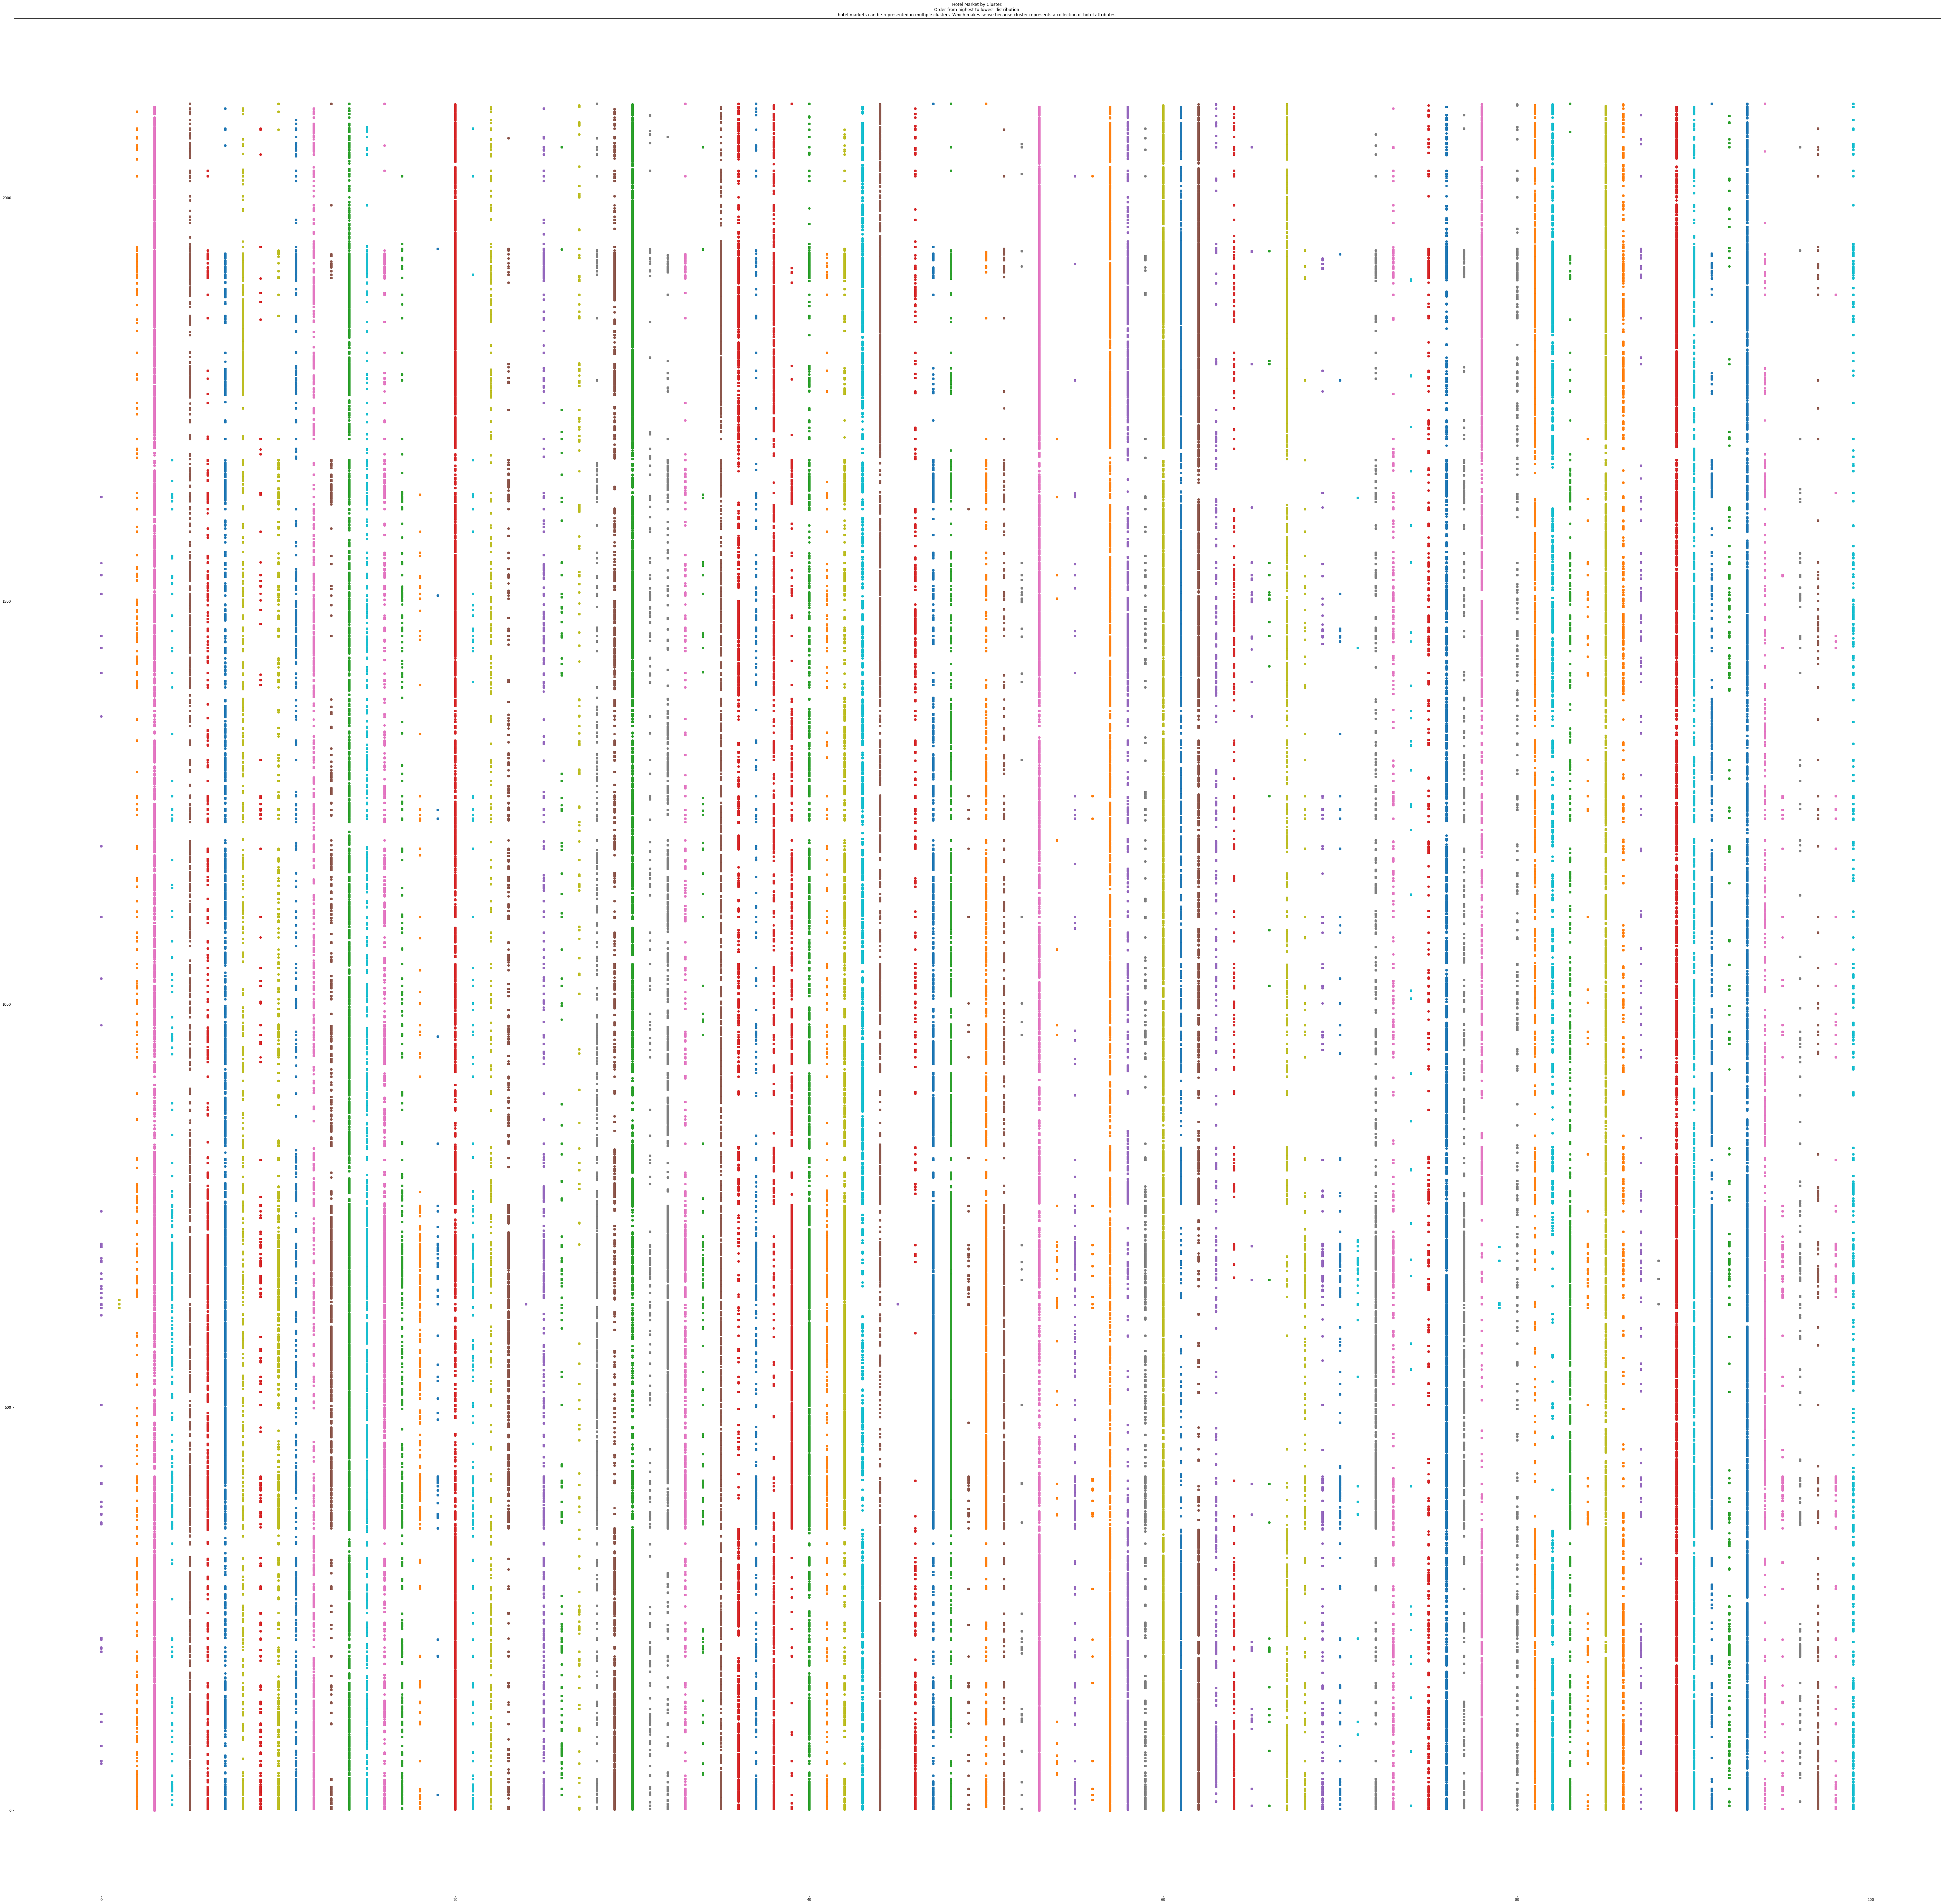

In [316]:
plt.rcParams['figure.figsize'] = [100,100]
fig,ax = plt.subplots()
for x in tdf['order'].unique():

    ax.scatter(tdf[tdf['order']==x]['hotel_cluster'],tdf[tdf['order']==x]['hotel_market'])
plt.title("Hotel Market by Cluster.\nOrder from highest to lowest distribution.\nhotel markets can be represented in multiple clusters. Which makes sense because cluster represents a collection of hotel attributes.")
plt.show()
plt.rcParams['figure.figsize'] = [10,10]

In [71]:
#//*** Focus on Top 100 hotel Markets
corr_col = "srch_destination_id"
predict_col = 'hotel_cluster'
corr_col = "hotel_cluster"
tdm = train_df[corr_col].value_counts().sort_values(ascending=False)
#train_df[train_df[col] == tdm.index[0]]
thm = pd.merge(train_df[train_df[corr_col] == tdm.index[0]],dest_df,on="srch_destination_id")
#thm

#//**** Build Correlat
for cluster in tdm.index[:1]:
    print("Building Temp Hotel Cluster:",cluster)
    thc_corr = pd.merge(train_df[train_df[corr_col] == tdm.index[0]],dest_df,on="srch_destination_id").corr()
    tthm = abs(thc_corr['srch_destination_id'].sort_values(ascending=False))
    fields = list(tthm[tthm > .2].sort_values(ascending=False).index)[1:]
    print(fields)
    
    

Building Temp Hotel Cluster: 91
['srch_destination_type_id', 'd52', 'd123', 'd23', 'd116', 'd95', 'd65', 'd135', 'd63', 'd70', 'd15', 'd148', 'd86', 'd100', 'd90', 'd147', 'd72', 'd106', 'd60', 'd125', 'd31', 'd98', 'd33', 'd107', 'd119', 'd3', 'd117', 'd38', 'd89', 'd40', 'd28', 'd6', 'd46', 'd139', 'd12', 'd113', 'd68', 'd133', 'd145', 'd104', 'd118', 'd92', 'd32', 'd64', 'd99', 'd87', 'd26', 'd140', 'd93', 'd54', 'd120', 'd42', 'd111', 'd37', 'd97', 'd82', 'd24', 'd62', 'd115', 'd19', 'd124', 'd146']


In [62]:
#//*** Focus on Top 100 hotel Markets
corr_col = "srch_destination_id"
predict_col = 'hotel_cluster'
corr_col = "hotel_cluster"
tdm = train_df[corr_col].value_counts().sort_values(ascending=False)
#train_df[train_df[col] == tdm.index[0]]
thm = pd.merge(train_df[train_df[corr_col] == tdm.index[0]],dest_df,on="srch_destination_id")
#thm

#//**** Build Correlat
for cluster in tdm.index[:3]:
    print("Building Temp Hotel Cluster:",cluster)
    thc_corr = pd.merge(train_df[train_df[corr_col] == tdm.index[0]],dest_df,on="srch_destination_id").corr()
    tthm = abs(thc_corr['hotel_market'].sort_values(ascending=False))
    fields = list(tthm[tthm > .2].sort_values(ascending=False).index)[1:]
    print(fields)
    

Building Temp Hotel Cluster: 91
['d26', 'd108', 'd25']
Building Temp Hotel Cluster: 41
['d26', 'd108', 'd25']
Building Temp Hotel Cluster: 48
['d26', 'd108', 'd25']


In [75]:
predict_col = 'srch_destination_id'
tdm = train_df[predict_col].value_counts().sort_values(ascending=False)

hc91 = train_df[train_df[predict_col] == tdm.index[0]]

hc91['hotel_cluster'].value_counts().sort_values(ascending=False)

thm = pd.merge(hc91,dest_df,on="srch_destination_id")
thm['hotel_cluster'].value_counts().sort_values(ascending=False)

1     309484
45    177232
79    167188
24    122226
54    108178
88     98853
51     59368
71     50337
49     36037
19     30191
84     19747
18     18531
91     17570
48     13404
50     11198
10     10924
94      9326
34      9004
47      7708
90      7042
83      7038
96      5806
41      5468
38      4921
40      4599
39      4533
92      3611
0       2306
23      1399
78      1377
15      1082
81      1055
99       973
76       796
14       744
32       738
60       710
35       677
89       605
12       543
31       471
44       169
57       110
93       107
30        79
68        49
3         34
5         30
56        30
59        26
53         6
7          6
85         5
20         4
6          2
Name: hotel_cluster, dtype: int64

In [81]:
train_df[train_df['is_booking']==1]



,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
20,2014-02-27 18:01:32,2,3,66,318,52078,NaN,756,0,1,4,2014-04-18,2014-04-20,2,0,1,8291,1,1,1,2,50,191,2
27,2013-06-15 15:38:05,30,4,195,548,56440,NaN,1048,0,1,9,2013-09-06,2013-09-14,2,0,1,1385,1,1,1,0,185,185,58
72,2014-11-23 18:02:20,30,4,195,991,47725,NaN,1048,0,0,9,2015-06-26,2015-06-28,2,0,1,8803,1,1,1,3,151,69,36
79,2014-01-03 16:30:17,2,3,66,462,41898,2454.8588,1482,0,1,1,2014-02-22,2014-02-27,3,0,2,12009,1,1,1,2,50,680,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37670275,2013-10-22 22:07:42,2,3,66,174,26232,113.0804,1198182,0,0,0,2013-10-23,2013-10-24,1,0,1,24144,6,1,1,2,50,967,7
37670277,2013-10-30 15:34:11,2,3,66,174,24103,254.2758,1198182,0,0,9,2013-10-30,2013-10-31,1,0,1,24144,6,1,1,2,50,967,42
37670281,2014-01-27 15:02:51,2,3,66,174,26232,535.0339,1198182,0,1,0,2014-02-23,2014-02-27,1,0,1,8273,1,1,1,2,50,660,68
37670285,2014-07-15 10:37:42,2,3,66,174,26232,649.6568,1198182,0,0,0,2014-07-27,2014-07-28,1,0,1,18811,1,1,1,2,50,592,77


91    1043720
41     772743
48     754033
64     704734
65     670960
5      620194
98     589178
59     570291
42     551605
21     550092
Name: hotel_cluster, dtype: int64


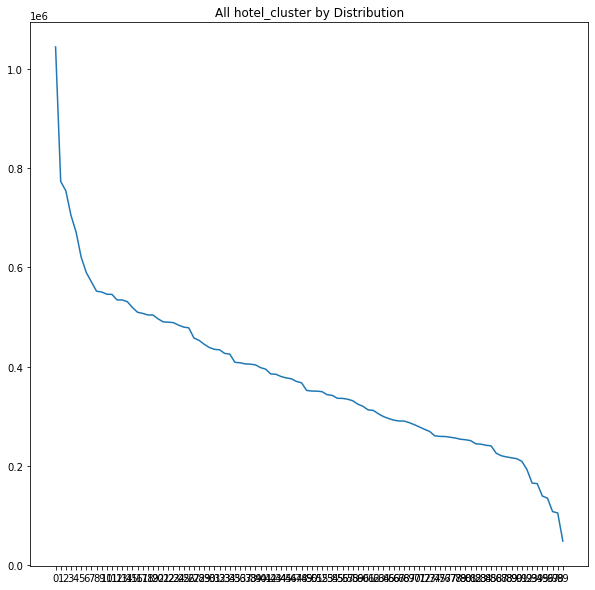

In [313]:

col = 'hotel_cluster'
tdm = train_df[col].value_counts().sort_values(ascending=False)
print(tdm[:10])
n=100

fig,ax = plt.subplots()
ax.plot(np.arange(len(tdm)),tdm)
plt.xticks(ticks=tdm.index)
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
#plt.figure(figsize=(40,100))
plt.title(f"All {col} by Distribution")
plt.show()






628     1771105
675     1586449
682      853798
19       808495
701      764911
         ...   
2016          7
2007          7
1218          6
373           6
2040          3
Name: hotel_market, Length: 2118, dtype: int64
2118


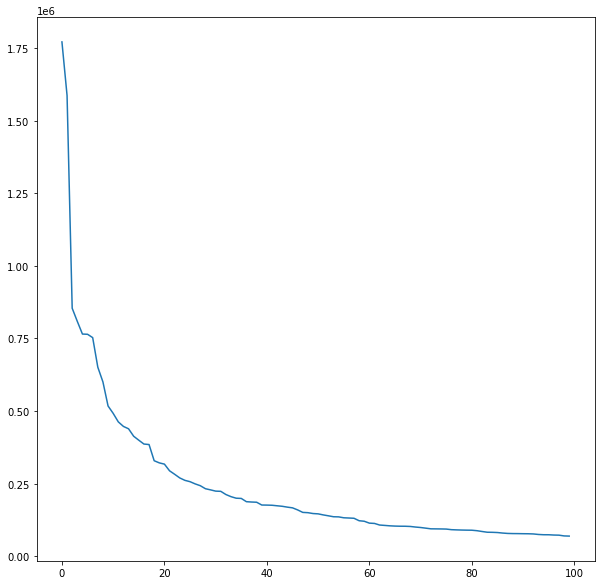

<Figure size 2880x7200 with 0 Axes>

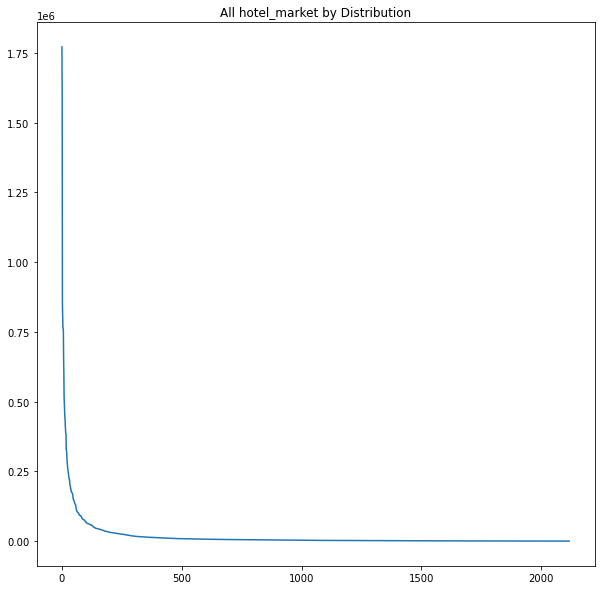

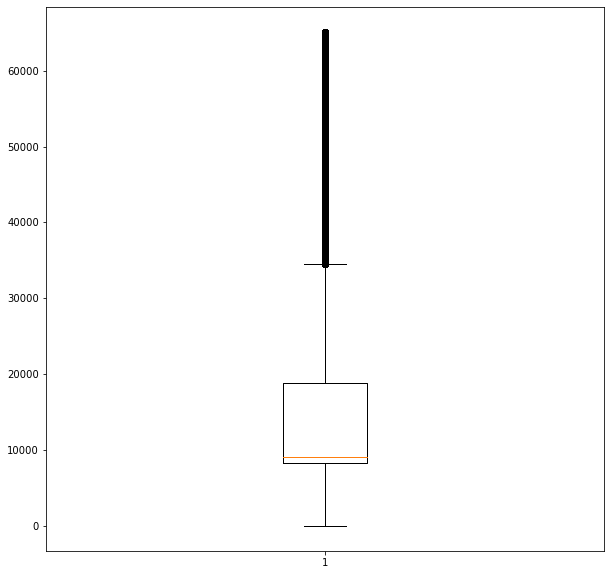

<Figure size 2880x7200 with 0 Axes>

In [314]:
col = 'hotel_market'
tdm = train_df[col].value_counts().sort_values(ascending=False)
print(tdm)
fig,ax = plt.subplots()
n=100

print(len(tdm))
ax.plot(np.arange(n),tdm[:n])
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
#plt.title("Top 100 Destinations by Distribution")
plt.show()

fig,ax = plt.subplots()
ax.plot(np.arange(len(tdm)),tdm)
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
#plt.figure(figsize=(40,100))
plt.title(f"All {col} by Distribution")
plt.show()

fig,ax = plt.subplots()


ax.boxplot(train_df['srch_destination_id'])
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
plt.show()

8250     1333657
8267     1005794
8791      619520
8268      529007
8253      498195
          ...   
63072          1
50246          1
13699          1
11747          1
46970          1
Name: srch_destination_id, Length: 59455, dtype: int64
59455


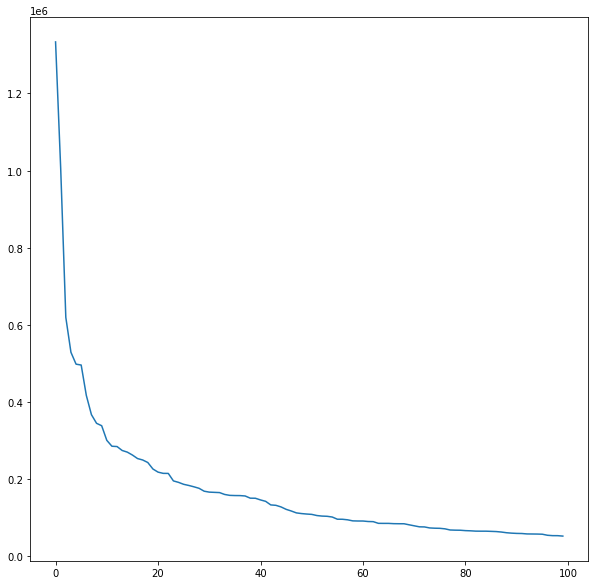

<Figure size 2880x7200 with 0 Axes>

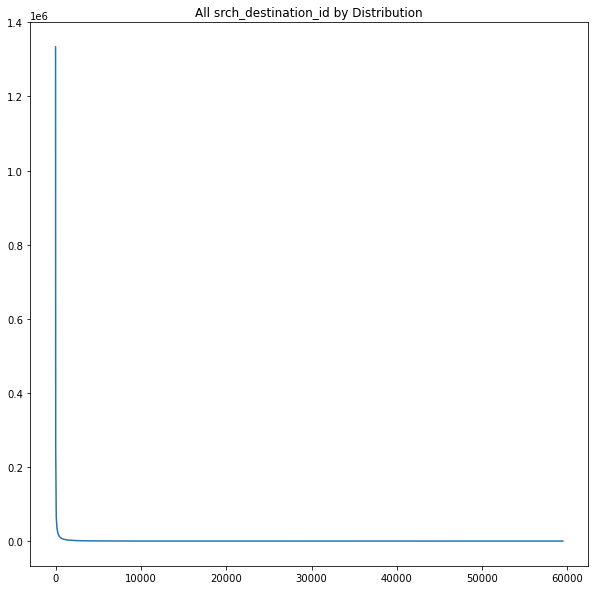

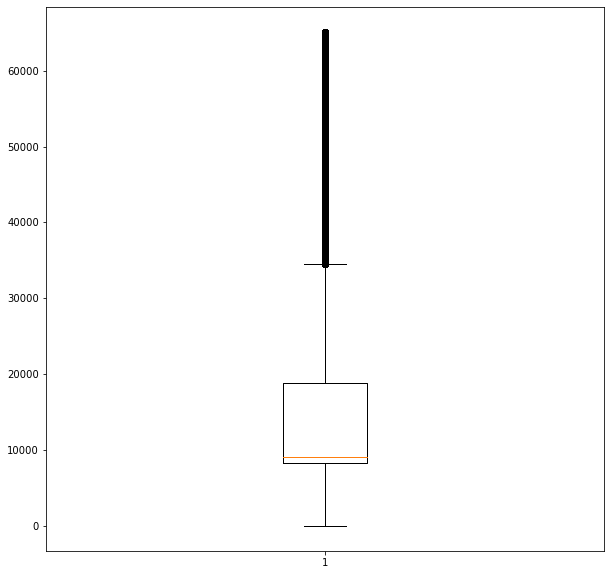

<Figure size 2880x7200 with 0 Axes>

In [315]:
col = 'srch_destination_id'
tdm = train_df[col].value_counts().sort_values(ascending=False)
print(tdm)
fig,ax = plt.subplots()
n=100

print(len(tdm))
ax.plot(np.arange(n),tdm[:n])
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
#plt.title("Top 100 Destinations by Distribution")
plt.show()

fig,ax = plt.subplots()
ax.plot(np.arange(len(tdm)),tdm)
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
#plt.figure(figsize=(40,100))
plt.title(f"All {col} by Distribution")
plt.show()

fig,ax = plt.subplots()


ax.boxplot(train_df['srch_destination_id'])
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
plt.show()

In [204]:
print(len(dest_df))
print(len(tdf))

tdm = train_df['srch_destination_id'].value_counts().sort_index()
tdf = pd.DataFrame(tdm)
tdf.columns=['count']
tdf['srch_destination_id'] = tdf.index
#tdf.sort_values('count',ascending=False).reindex()
tdf = pd.merge(tdf,dest_df,on='srch_destination_id').sort_values('count',ascending=False)
tdf['dex'] = np.arange(len(tdf),0,-1)
#tdf['dex'] = np.arange(len(tdf))
tdf[:100].corr()['count'].sort_values(ascending=False)


62106
152


count                  1.000000
dex                    0.691372
d14                    0.440239
d37                    0.415774
d93                    0.401663
d49                    0.368687
d43                    0.355979
d29                    0.343420
d6                     0.326918
d75                    0.322387
d20                    0.302406
d84                    0.266887
d122                   0.212612
d74                    0.194686
d17                    0.185719
d91                    0.164073
d16                    0.145956
d108                   0.135565
d130                   0.131168
d41                    0.127130
d139                   0.107649
d121                   0.079257
d128                  -0.001958
d35                   -0.005125
d131                  -0.012259
d92                   -0.012416
d9                    -0.018395
d85                   -0.065208
d132                  -0.068568
d137                  -0.068595
d30                   -0.087364
d103    

In [205]:
tdf.corr()['count'].sort_values(ascending=False)

count                  1.000000
dex                    0.101472
d37                    0.071675
d93                    0.071381
d139                   0.069862
d108                   0.069553
d49                    0.069042
d6                     0.065346
d43                    0.064384
d132                   0.060326
d14                    0.054539
d91                    0.053967
d5                     0.051171
d122                   0.049373
d29                    0.047974
d75                    0.044843
d58                    0.042839
d74                    0.042473
d41                    0.036974
d80                    0.036971
d16                    0.034772
d9                     0.033397
d128                   0.032006
d130                   0.025678
d103                   0.023083
d84                    0.019687
d121                   0.017041
d13                    0.011922
d53                    0.009801
d20                    0.007331
d34                    0.004070
d77     

In [191]:
for x,y in tdf.sort_values(ascending=False).items():
    print(x,y)

dex 1.0
d43 0.21980802979511568
d37 0.2149462261239023
d93 0.20750388257357372
d132 0.1974251581007706
d5 0.17414376774450394
d108 0.16919995411993496
d49 0.16534942205917913
d122 0.16412105368263571
d58 0.1560570440800278
d139 0.15115145798471255
d91 0.14604199405058244
d80 0.14199071734795604
d29 0.1419837411425346
d16 0.12823459289269987
d6 0.12458912632850158
d14 0.1034174276414628
d74 0.10336395517856473
count 0.10147175536175382
d128 0.10123482563993717
d130 0.08745249695946869
d56 0.08387696433509885
d13 0.07403794264567634
d9 0.06662386914246077
d75 0.05567773520729444
d34 0.04864421317750482
d103 0.04373386857846971
d83 0.03970162755749239
d53 0.02950881456844489
d41 0.026079892554623077
d121 0.024812500867159807
d55 0.02103269533946057
d79 0.016814486729583376
d94 0.013569709637017598
d66 0.010000215527701318
d71 0.0025759829454990975
d11 -0.00045296235051197454
d137 -0.0017937674527404679
d136 -0.010700332486846643
d77 -0.011754193451494034
d114 -0.013785226857743318
d35 -0.

In [149]:

tdf['srch_destination_id'] = tdm.index
print(tdm.sort_values(ascending=False))
print(tdm.sort_values(ascending=False).index)
tdf['count'] = tdm
print(tdf.sort_values('count',ascending=False))
tdf = pd.merge(tdf,dest_df,on='srch_destination_id')
tdf.sort_values('count',ascending=False)

8250     1333657
8267     1005794
8791      619520
8268      529007
8253      498195
          ...   
40491          1
7928           1
40493          1
40497          1
65107          1
Name: srch_destination_id, Length: 59455, dtype: int64
Int64Index([ 8250,  8267,  8791,  8268,  8253,  8745,  8279, 11439,  8260,
            12206,
            ...
            40461, 40463, 40478,  7931, 40481, 40491,  7928, 40493, 40497,
            65107],
           dtype='int64', length=59455)
       srch_destination_id      count
8250                  8589  1333657.0
8267                  8607  1005794.0
8791                  9172   619520.0
8268                  8608   529007.0
8253                  8593   498195.0
...                    ...        ...
59439                65051        NaN
59442                65056        NaN
59444                65059        NaN
59446                65063        NaN
59454                65107        NaN

[59455 rows x 2 columns]


,srch_destination_id,count,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
8151,8589,1333657.0,-2.254624,-2.254624,-2.133328,-2.133328,-2.055028,-1.831053,-2.254624,-2.254624,-2.254624,-2.254624,-2.133328,-2.254624,-2.254624,-2.208201,-2.254624,-2.154667,-2.183179,-2.133328,-2.254624,-2.133602,-2.133328,-2.099534,-2.254624,-2.254624,-2.216082,-2.254624,-1.897262,-2.254624,-2.047140,-2.254624,-2.254624,-2.133328,-2.254624,-2.022753,-2.174477,-2.254624,-1.643571,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.031832,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-1.810818,-2.254624,-2.254624,-2.254624,-2.133328,-2.254624,-1.984232,-2.254624,-2.254624,-1.654379,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.248278,-2.218762,-2.133328,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.004888,-2.254624,-2.254624,-2.254624,-2.055028,-2.254624,-2.055028,-2.254624,-2.254624,-2.133328,-2.254624,-2.254624,-2.254624,-2.254624,-2.177876,-2.254624,-2.254624,-2.177500,-2.254624,-1.705994,-2.254624,-2.254624,-2.146012,-2.254624,-2.254624,-2.133328,-2.254624,-2.254624,-2.133328,-2.099408,-2.254624,-2.254624,-2.133328,-2.254624,-2.057438,-2.188827,-2.254624,-2.254624,-2.119524,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624,-2.243168,-2.133328,-2.254624,-2.254624,-2.254624,-2.087991,-2.254624,-2.243608,-2.254624,-2.133328,-2.243168,-2.012043,-2.254624,-2.254624,-2.254624,-2.059250,-2.119524,-2.254624,-2.010214,-2.254624,-2.133328,-2.254624,-2.254624,-2.133328,-2.254624,-2.254624,-2.254624,-2.254624,-2.254624
8168,8607,1005794.0,-2.202516,-2.202516,-2.202516,-2.202516,-2.181291,-2.046058,-2.202516,-2.202516,-2.195449,-2.202516,-2.181651,-2.202516,-2.202516,-2.139138,-2.202516,-2.188496,-2.176420,-2.202516,-2.202516,-2.202516,-1.808040,-2.202516,-2.202516,-2.163393,-2.202516,-2.202516,-2.171916,-2.202516,-2.169214,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-1.841791,-2.195449,-2.202516,-2.195449,-2.202516,-2.202516,-2.166726,-2.176878,-2.202516,-2.202516,-2.202516,-2.202516,-2.107612,-2.202516,-2.202516,-2.202516,-2.105868,-2.202516,-2.188496,-2.195449,-2.086952,-1.729577,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.174913,-2.202516,-2.189202,-2.202516,-2.189895,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.134036,-2.188496,-2.202516,-2.202516,-2.125339,-2.202516,-2.202516,-2.148909,-2.202516,-1.884941,-2.121304,-2.202516,-2.091472,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.195040,-2.202516,-2.202516,-2.174894,-2.188496,-2.202516,-2.161673,-2.194989,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.195449,-2.188496,-2.202516,-2.202516,-2.202516,-2.202516,-2.202516,-2.188496,-2.202516,-2.202516,-2.202516,-2.064901,-2.202516,-2.202516,-2.202516,-2.202516,-2.155305,-2.202516,-2.024214,-2.195449,-2.202516,-2.202516,-2.202516,-2.202516,-2.195449,-2.202516,-2.202516,-2.195449,-2.202516
8681,9172,619520.0,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.154016,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.154016,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.173727,-2.1737

In [132]:
dest_df

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.153316,-2.186008,-2.224164,-2.224164,-2.224164,-2.128237,-2.158309,

In [20]:
np.log(train_df['orig_destination_distance'])

0           7.711667
1           7.711667
2           7.711667
3           6.816947
4           6.817421
              ...   
37670288    7.761493
37670289    6.521520
37670290    6.504553
37670291    4.667463
37670292    4.667463
Name: orig_destination_distance, Length: 37670293, dtype: float64

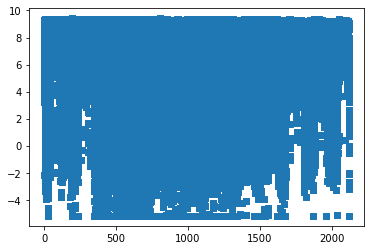

<Figure size 2880x7200 with 0 Axes>

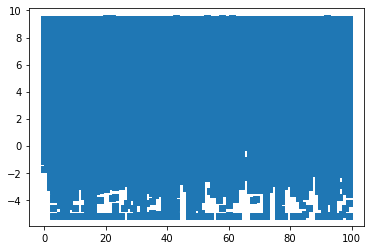

<Figure size 2880x7200 with 0 Axes>

In [27]:
fig,ax = plt.subplots()


ax.scatter(train_df['hotel_market'],np.log(train_df['orig_destination_distance']),marker=",")
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
plt.show()

fig,ax = plt.subplots()

ax.scatter(train_df['hotel_cluster'],np.log(train_df['orig_destination_distance']),marker=",")
#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
plt.show()


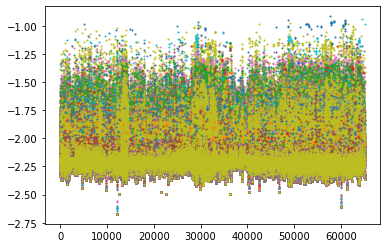

<Figure size 2880x7200 with 0 Axes>

In [4]:
# //*** CODE HERE
dest_df

display_size = 40

fig,ax = plt.subplots()

for col in dest_df.columns[1:]:
    
    
    
    ax.scatter(dest_df['srch_destination_id'],dest_df[col],label=col,s=1)


#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.025))
plt.figure(figsize=(40,100))
plt.show()

In [9]:
# //*** CODE HERE
dest_df

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.153316,-2.186008,-2.224164,-2.224164,-2.224164,-2.128237,-2.158309,

In [10]:
# //*** CODE HERE
submit_df

,id,hotel_cluster
0,0,99 1
1,1,99 1
2,2,99 1
3,3,99 1
4,4,99 1
...,...,...
2528238,2528238,99 1
2528239,2528239,99 1
2528240,2528240,99 1
2528241,2528241,99 1


In [15]:
# //*** CODE HERE
ids = []
for dst in train_df['srch_destination_id'].unique():
    if dst not in dest_df['srch_destination_id']:
        if dst not in ids:
            ids.append(dst)

print(len(ids))
print(ids)

2317
[65035, 63687, 62134, 64627, 63067, 64591, 64504, 63642, 64999, 62173, 63994, 63851, 64741, 62927, 64253, 62929, 64711, 64729, 64570, 64573, 64184, 62824, 64811, 64871, 64778, 62146, 62166, 64925, 62231, 62919, 64423, 64603, 64560, 63873, 62983, 64421, 64506, 63885, 64941, 64515, 63685, 64630, 64730, 62634, 64683, 62466, 64986, 63269, 64709, 62962, 62188, 63734, 62886, 62932, 64602, 64940, 64379, 63087, 64159, 62880, 64436, 62212, 63231, 62568, 64134, 62202, 62509, 62368, 63459, 64574, 63363, 64246, 63058, 62601, 63633, 64444, 64397, 63896, 64027, 63950, 64130, 64472, 63480, 64739, 64927, 62321, 64594, 63795, 63035, 62218, 64836, 63673, 63357, 64456, 64262, 64665, 64292, 64595, 64418, 63859, 64893, 64417, 63302, 64420, 63477, 62998, 63237, 63978, 62584, 64492, 62299, 63137, 62571, 64516, 64415, 63273, 63400, 64975, 64393, 64777, 62529, 62508, 62484, 62829, 62165, 65031, 64518, 63299, 62798, 62514, 63180, 64304, 64575, 62874, 64676, 65013, 63971, 62945, 62238, 64059, 62510, 63839, 